# Predicting diabetes with Pima Indians

![](https://github.com/EAISI/discover-projects/blob/main/pima-indians-diabetes/women-Pima-shinny-game-field-hockey.jpg?raw=true)

## Objectives

- Example end-to-end supervised learning workflow with Pima Indians
- Focus on conceptual understanding of machine learning
- Demonstrate use of Predictive Power Score (PPS)
- Demonstrate capabilities of low-code tools
- Demonstrate use of `average_precision_score` ([link](https://github.com/pycaret/pycaret/issues/806#issuecomment-721993086))
- Demonstrate SHAP values

## Attribution

### Dataset
- Pima Indians paper ([original paper](https://github.com/EAISI/discover-projects/blob/main/pima-indians-diabetes/schulz2006effects.pdf))
- Kaggle datacard ([link](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data))

### Python libraries
- Altair ([docs](https://altair-viz.github.io/))
- ydata-profiling ([docs](https://docs.profiling.ydata.ai/4.6/))
- Predictive Power Score (PPS, [GitHub](https://github.com/8080labs/ppscore/), [blog](https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598))
- PyCaret: open-source, low-code machine learning library in Python that automates machine learning workflows ([link](https://pycaret.org/))

*Pima Indians with PyCaret* © 2023 by [Daniel Kapitan](https://kapitan.net) is licensed under [Attribution-ShareAlike 4.0 International](http://creativecommons.org/licenses/by-sa/4.0/?ref=chooser-v1).
![](https://upload.wikimedia.org/wikipedia/commons/e/e5/CC_BY-SA_icon.svg)

In [1]:
import altair as alt
import requests
import pandas as pd
import ppscore as pps
from pycaret.classification import *
import shap
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport


# customize Altair
def y_axis():
    return {
        "config": {
            "axisX": {"grid": False},
            "axisY": {
                "domain": False,
                "gridDash": [2, 4],
                "tickSize": 0,
                "titleAlign": "right",
                "titleAngle": 0,
                "titleX": -5,
                "titleY": -10,
            },
            "view": {
                "stroke": "transparent",
                # To keep the same height and width as the default theme:
                "continuousHeight": 300,
                "continuousWidth": 400,
            },
        }
    }


alt.themes.register("y_axis", y_axis)
alt.themes.enable("y_axis");

## Read and explore the data

In [2]:
%%time
df = pd.read_csv("diabetes.csv").astype({"Outcome": bool})
train, test = train_test_split(df, test_size=0.3)
profile = ProfileReport(train, minimal=True, title="Pima Indians Profiling Report")
profile.to_file("pima-indians-profiling-report-minimal.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 5.82 s, sys: 95.3 ms, total: 5.92 s
Wall time: 1.65 s


In [3]:
profile.to_notebook_iframe()

## Investigate features with largest predictive power

We use the Predictive Power Score to evaluate which features have the highest predictive power with respect to `Outcome`.

In [4]:
predictors = (
    pps.predictors(train, "Outcome")
    .round(3)
    .iloc[:, :-1]
)
base = (
    alt.Chart(predictors)
    .encode(
        y=alt.Y("x:N").sort("-x"),
        x="ppscore",
        tooltip=["x", "ppscore"],
    )
)
base.mark_bar() + base.mark_text(align="center", dy=-5)

alt.LayerChart(...)

## Investigate colinearity

In [5]:
pps.matrix(train)

x                         y   ppscore            case  \
0   Pregnancies               Pregnancies  1.000000  predict_itself   
1   Pregnancies                   Glucose  0.005352      regression   
2   Pregnancies             BloodPressure  0.004610      regression   
3   Pregnancies             SkinThickness  0.000000      regression   
4   Pregnancies                   Insulin  0.000000      regression   
..          ...                       ...       ...             ...   
76      Outcome                   Insulin  0.000000      regression   
77      Outcome                       BMI  0.034817      regression   
78      Outcome  DiabetesPedigreeFunction  0.000000      regression   
79      Outcome                       Age  0.000000      regression   
80      Outcome                   Outcome  1.000000  predict_itself   

    is_valid_score               metric  baseline_score  model_score  \
0             True                 None        0.000000     1.000000   
1             True  mean absolute error       25.104283    24.969927   
2             True  mean absolute error       12.642458    12.584176   
3             True  mean absolute error       13.720670    14.026252   
4             True  mean absolute error       80.618250    87.273318   
..             ...                  ...             ...          ...   
76            True  mean absolute error       80.618250    85.124606   
77            True  mean absolute error        5.700745     5.502260   
78            True  mean absolute error        0.241533     0.250626   
79            True  mean absolute error        8.791434     8.853369   
80            True                 None        0.000000     1.000000   

                      model  
0                      None  
1   DecisionTreeRegressor()  
2   DecisionTreeRegressor()  
3   DecisionTreeRegressor()  
4   DecisionTreeRegressor()  
..                      ...  
76  DecisionTreeRegressor()  
77  DecisionTreeRegressor()  
78  DecisionTreeRegressor()  
79  DecisionTreeRegressor()  
80                     None  

[81 rows x 9 columns]

In [6]:
pps_matrix = (
    pps.matrix(
        train.loc[:, predictors.query("ppscore > 0")["x"].tolist()],
    )
    .loc[:, ["x", "y", "ppscore"]]
    .round(3)
)
(
    alt.Chart(pps_matrix)
    .mark_rect()
    .encode(
        x="x:O",
        y="y:O",
        color="ppscore:Q",
        tooltip=["x", "y", "ppscore"])
).properties(width=500, height=500)

alt.Chart(...)

## Build models

In [7]:
cls = setup(data = train, 
             target = 'Outcome',
             numeric_imputation = 'mean',
             feature_selection = False,
             pca=False,
             remove_multicollinearity=True,
             remove_outliers = False,
             normalize = True,
             )
add_metric('apc', 'APC', average_precision_score, target = 'pred_proba');

In [8]:
%%time
best_model = compare_models(include=["et", "lightgbm", "rf", "dt"], sort="APC")

CPU times: user 555 ms, sys: 126 ms, total: 680 ms
Wall time: 3.69 s


## Evaluation

In [10]:
predictions = (
    predict_model(best_model, data=test.iloc[:, :-1])
)
predictions.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin        BMI  \
386            5      116             74             29        0  32.299999   
65             5       99             74             27        0  29.000000   
569            0      121             66             30      165  34.299999   
539            3      129             92             49      155  36.400002   
134            2       96             68             13       49  21.100000   

     DiabetesPedigreeFunction  Age  prediction_label  prediction_score  
386                     0.660   35                 1              0.59  
65                      0.203   32                 0              0.82  
569                     0.203   33                 0              0.52  
539                     0.968   32                 1              0.84  
134                     0.647   26                 0              0.99

In [11]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## SHAP

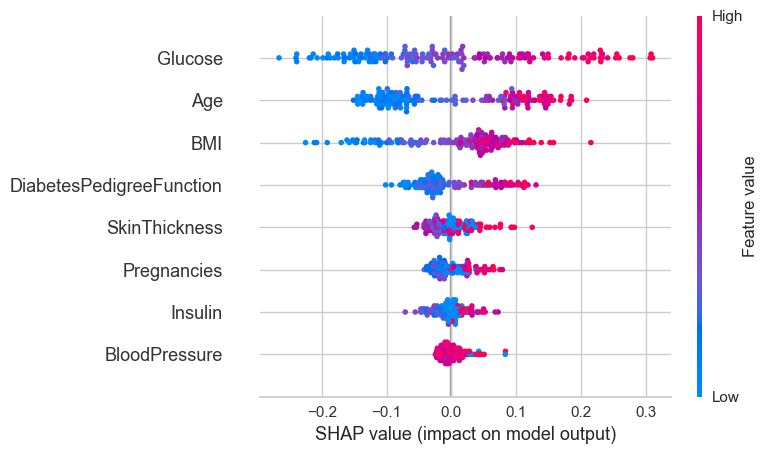

In [12]:
interpret_model(best_model)

In [13]:
interpret_model(best_model, plot="reason", observation=1)

In [14]:
interpret_model(best_model, plot="reason")